In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
method_tags = ['NC', 'DS', 'DS+MRH', 'DSX', 'DSX+MRH']
df = pd.read_csv('outs/rt_81_2022-05/compare/benchmark/numer_results.csv')
for m in method_tags[1:]:
    df['prc_' + m] = (-df[m]+df['NC'])/(df['NC'])*100
    df['prc_' + m] = df['prc_' + m].round(decimals=2)
df

,parameter,prc_cancel,NC,DS,DS+MRH,DSX,DSX+MRH,prc_DS,prc_DS+MRH,prc_DSX,prc_DSX+MRH
0,cv_h,0,0.613486,0.540814,0.478496,0.510909,0.459030,11.85,22.00,16.72,25.18
1,cv_h,12,0.668136,0.537962,0.496877,0.474221,0.488177,19.48,25.63,29.02,26.93
2,cv_h,25,0.687957,0.574626,0.557743,0.612999,0.547815,16.47,18.93,10.90,20.37
3,wt,0,4.946001,4.655401,4.398495,4.540423,4.336935,5.88,11.07,8.20,12.31
4,wt,12,6.340714,5.590151,5.464301,5.548956,5.708345,11.84,13.82,12.49,9.97
5,wt,25,8.189479,7.478367,7.391268,8.092041,7.475365,8.68,9.75,1.19,8.72
6,rbt,0,7.313417,7.204493,6.379177,6.711204,6.365581,1.49,12.77,8.23,12.96
7,rbt,12,10.935478,9.244914,9.096381,9.385036,9.964972,15.46,16.82,14.18,8.87
8,rbt,25,16.261185,15.165447,14.806164,17.153449,14.916960,6.74,8.95,-5.49,8.27
9,95load,0,48.700000,52.000000,47.250000,47.000000,46.000000,-6.78,2.98,3.49,5.54


In [12]:
method_tags = ['NC53', 'NC80', 'DS+MRH53', 'DS+MRH80', 'DSX+MRH53', 'DSX+MRH80']
df = pd.read_csv('out/compare/infinite capacity/numer_results.csv')
for m in method_tags[1:]:
    df['prc_' + m] = (-df[m]+df['NC53'])/(df['NC53'])*100
    df['prc_' + m] = df['prc_' + m].round(decimals=2)
df

,parameter,prc_cancel,NC53,NC80,DS+MRH53,DS+MRH80,DSX+MRH53,DSX+MRH80,prc_NC80,prc_DS+MRH53,prc_DS+MRH80,prc_DSX+MRH53,prc_DSX+MRH80
0,cv_h,12,0.635314,0.645532,0.482580,0.485673,0.466591,0.467891,-1.61,24.04,23.55,26.56,26.35
1,cv_h,25,0.758590,0.813602,0.560532,0.570365,0.566277,0.559839,-7.25,26.11,24.81,25.35,26.20
2,wt,12,4.410861,4.352093,3.740851,3.671241,3.667786,3.789103,1.33,15.19,16.77,16.85,14.10
3,wt,25,6.347503,6.211394,5.087219,4.796748,5.235302,4.912688,2.14,19.85,24.43,17.52,22.60
4,rbt,12,9.092081,9.085797,7.173659,6.868992,7.040866,7.171299,0.07,21.10,24.45,22.56,21.13
5,rbt,25,14.583704,14.117582,10.566865,10.355100,11.221716,10.553066,3.20,27.54,29.00,23.05,27.64
6,95load,12,53.000000,61.000000,53.000000,61.000000,52.150000,55.000000,-15.09,0.00,-15.09,1.60,-3.77
7,95load,25,53.000000,76.000000,53.000000,68.000000,53.000000,67.200000,-43.40,0.00,-28.30,0.00,-26.79
8,50load,12,25.000000,23.000000,25.000000,25.000000,26.000000,25.000000,8.00,0.00,0.00,-4.00,0.00
9,50load,25,31.000000,26.000000,32.000000,31.000000,31.000000,29.500000,16.13,-3.23,0.00,0.00,4.84


In [19]:
tdf80 = pd.read_pickle('out/NC/0729-011457-trip_record_ob.pkl')
tdf53 = pd.read_pickle('out/NC/0729-011546-trip_record_ob.pkl')
pdf80 = pd.read_pickle('out/NC/0729-011457-pax_record_ob.pkl')
pdf53 = pd.read_pickle('out/NC/0729-011546-pax_record_ob.pkl')
denied80 = pdf80[pdf80['denied'] == 1].copy()
denied53 = pdf53[pdf53['denied'] == 1].copy()
notdenied80 = pdf80[pdf80['denied'] == 0].copy()
notdenied53 = pdf53[pdf53['denied'] == 0].copy()

In [35]:
def wtime(t0, t1, df):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    wt = tmp_df['board_time'] - tmp_df['arr_time']
    return round(wt.mean(), 1)
def ratio(t0, t1, df):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    denied = tmp_df[tmp_df['denied'] == 1].shape[0]
    tot = tmp_df.shape[0]
    return str(round(denied/tot*100))+'%'
def wtime_pctile(t0, t1, df, pctile=0.95):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    wt = tmp_df['board_time'] - tmp_df['arr_time']
    return round(wt.quantile(pctile), 1)
def wtime_subset(t0, t1, df, stops, o_idx, d_idx):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    d_stops = {s: stops.index(s) for s in stops}
    tmp_df = tmp_df.replace({'orig_idx':d_stops, 'dest_idx':d_stops})
    tmp_df = tmp_df[(tmp_df['orig_idx']>=o_idx) & (tmp_df['dest_idx']<=d_idx)]
    wt = tmp_df['board_time'] - tmp_df['arr_time']
    return round(wt.mean(), 1)

In [180]:
ts = [6.0*60*60, 8.0*60*60]
ts2 = [6.0*60*60, 7.0*60*60]
ts3 = [7.0*60*60, 8.0*60*60]
for t in (ts, ts2, ts3):
    print('----')
    print(t)
    print(f'capacity 53 with ratio {ratio(*t, pdf53)}')
    print(f'all {wtime(*t, pdf53)} denied {wtime(*t, denied53)} and not denied {wtime(*t, notdenied53)}')
    print(f'capacity 80 with ratio {ratio(*t, pdf80)}')
    print(f'all {wtime(*t, pdf80)} denied {wtime(*t, denied80)} and not denied {wtime(*t, notdenied80)}')

----
[21600.0, 28800.0]
capacity 53 with ratio 6%
all 383.8 denied 966.5 and not denied 349.8
capacity 80 with ratio 1%
all 381.1 denied 1119.3 and not denied 372.4
----
[21600.0, 25200.0]
capacity 53 with ratio 3%
all 459.4 denied 1169.0 and not denied 438.8
capacity 80 with ratio 0%
all 453.6 denied 1853.1 and not denied 451.2
----
[25200.0, 28800.0]
capacity 53 with ratio 7%
all 354.8 denied 933.0 and not denied 314.2
capacity 80 with ratio 2%
all 353.2 denied 1087.0 and not denied 341.7


In [45]:
from Inputs import STOPS_OUT_FULL_PATT
scenarios = [['NC/0729-011407', 'NC/0729-011546'],
             ['NC/0729-011316', 'NC/0729-011457'],
             ['DS+MRH/0729-011427', 'DS+MRH/0729-011604'],
             ['DS+MRH/0729-011337', 'DS+MRH/0729-011517'],
             ['DSX+MRH/0729-011447', 'DSX+MRH/0729-011623'],
             ['DSX+MRH/0729-011357', 'DSX+MRH/0729-011536']]
method_tags = ['NC53', 'NC80', 'DS+MRH53', 'DS+MRH80', 'DSX+MRH53', 'DSX+MRH80']
wts = {m: [] for m in method_tags}
wts95 = {m: [] for m in method_tags}
ts = [6.5*60*60, 8.5*60*60]
for i in range(len(scenarios)):
    for j in range(len(scenarios[i])):
        df = pd.read_pickle('out/' + scenarios[i][j] + '-pax_record_ob.pkl')
        wts[method_tags[i]].append(wtime_pctile(*ts, df, pctile=0.95)/60)
        wts95[method_tags[i]].append(wtime_subset(*ts, df, STOPS_OUT_FULL_PATT, 49, 66)/60)
wts, wts95
# print(wtime_pctile(*ts, pdf53, pctile=0.95),wtime_pctile(*ts, pdf80,pctile=0.95))
# print(wtime_subset(*ts, pdf53, STOPS_OUT_FULL_PATT, 49, 66), wtime_subset(*ts, pdf80, STOPS_OUT_FULL_PATT, 49, 66))

({'NC53': [11.705, 19.573333333333334],
  'NC80': [11.868333333333334, 18.366666666666667],
  'DS+MRH53': [9.573333333333332, 14.331666666666667],
  'DS+MRH80': [9.146666666666667, 13.291666666666666],
  'DSX+MRH53': [9.2, 14.94],
  'DSX+MRH80': [9.421666666666665, 13.478333333333333]},
 {'NC53': [5.801666666666667, 8.45],
  'NC80': [5.376666666666667, 7.7716666666666665],
  'DS+MRH53': [4.8566666666666665, 6.595],
  'DS+MRH80': [4.503333333333333, 5.588333333333334],
  'DSX+MRH53': [4.446666666666667, 6.448333333333333],
  'DSX+MRH80': [4.395, 5.59]})

In [188]:
tdf53[(tdf53['trip_id'] == 911318020) & (tdf53['replication'] == 20) & (tdf53['stop_sequence'] >= 40)]

,bus_id,trip_id,stop_id,arr_sec,dep_sec,pax_load,ons,offs,denied,hold_time,skipped,schd_sec,stop_sequence,dist_traveled,expressed,replication
32969,897302,911318020,427,31616.161833,31627.561833,53,3,3,7,0,0,31008.0,40,26022,0,20
32973,897302,911318020,428,31665.534035,31679.515533,52,4,5,0,0,0,31058.0,41,26746,0,20
32979,897302,911318020,429,31728.522419,31735.422419,51,1,2,0,0,0,31101.0,42,27382,0,20
32983,897302,911318020,430,31757.254242,31773.254242,53,5,3,1,0,0,31155.0,43,28209,0,20
32987,897302,911318020,431,31830.294327,31830.294327,53,0,0,7,0,0,31202.0,44,28900,0,20
32993,897302,911318020,4727,31907.495602,31932.695602,53,9,9,3,0,0,31227.0,45,29212,0,20
32998,897302,911318020,432,31977.964925,31987.064925,53,2,2,8,0,0,31260.0,46,29648,0,20
33004,897302,911318020,15279,32048.255079,32048.255079,53,0,0,9,0,0,31344.0,47,30496,0,20
33006,897302,911318020,16049,32064.816417,32073.916417,53,2,2,14,0,0,31396.0,48,30941,0,20
33013,897302,911318020,435,32135.323687,32143.171072,53,1,1,18,0,0,31462.0,49,31668,0,20


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tdf = pd.read_csv('ins/rt_81_2022-05/gtfs_trips.txt')
df = pd.read_csv('ins/rt_81_2022-05/avl.csv')
sdf = pd.read_csv('ins/rt_81_2022-05/gtfs_stop_times.txt')

In [62]:
df['arr_sec'] = (pd.to_datetime(df['event_time'])- pd.to_datetime('2022-05-02 00:00:00')).dt.total_seconds()%86400
df['arr_sec'] = df['arr_sec'].round()
df['dep_sec'] = df['arr_sec'] + df['dwell_time']
df = df[df['trip_id'].notnull()].copy()
df = df[df['stop_id'].notnull()].copy()
df['trip_id'] = df['trip_id'].astype(int)
df['stop_id'] = df['stop_id'].astype(int).astype(str)
df = df.rename(columns={'event_time':'arr_time'})
# df.to_csv('in/rt_81_2022-05/avl2.csv', index=False)

In [77]:
cdf = pd.read_csv('ins/rt_81_2022-05/gtfs_calendar.txt')

In [79]:
cdf[cdf['service_id'].isin(['64601','64701'])]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,64601,1,1,1,1,1,0,0,20220413,20220416
42,64701,1,1,1,1,1,0,0,20220417,20220630


In [85]:
cdf['start_dt'] = pd.to_datetime(cdf['start_date'].astype(str))
cdf['end_dt'] = pd.to_datetime(cdf['end_date'].astype(str))
cdf_keep = cdf[(cdf['start_dt']<=pd.to_datetime('20220501')) & (cdf['end_dt']>=pd.to_datetime('20220531'))]
# cdf_keep.to_csv('ins/rt_81_2022-05/gtfs_calendar.txt')

In [31]:
odt = np.load('ins/rt_81_2022-05/odt_flows_30.npy')
odt_stops = np.load('ins/rt_81_2022-05/odt_stops.npy')
stops_east = np.load('ins/rt_81_2022-05/stops_out_full_patt.pkl', allow_pickle=True)
on_rates = np.load('ins/rt_81_2022-05/apc_on_rates_30.npy')
off_rates = np.load('ins/rt_81_2022-05/apc_off_rates_30.npy')
odt_ons = np.nansum(odt, axis=-1)
odt_offs = np.nansum(odt, axis=-2)

In [104]:
def get_zero_ons_stops(od_ons, stops_east, bin_nr, apc_ons):
    ons = odt_ons[bin_nr,:]
    zero_stops = odt_stops[np.where(ons == 0)[0]].tolist()
    zero_ons_stops = []
    zero_ons_idx = []
    for z in zero_stops:
        if z in stops_east[:-1]:
            zero_ons_idx.append(stops_east.index(z))
            zero_ons_stops.append(stops_east[stops_east.index(z)])
    zero_ons_apc = apc_ons[bin_nr, zero_ons_idx].tolist()
    zero_ons_apc = [round(z, 1) for z in zero_ons_apc]
    return zero_ons_stops, zero_ons_apc

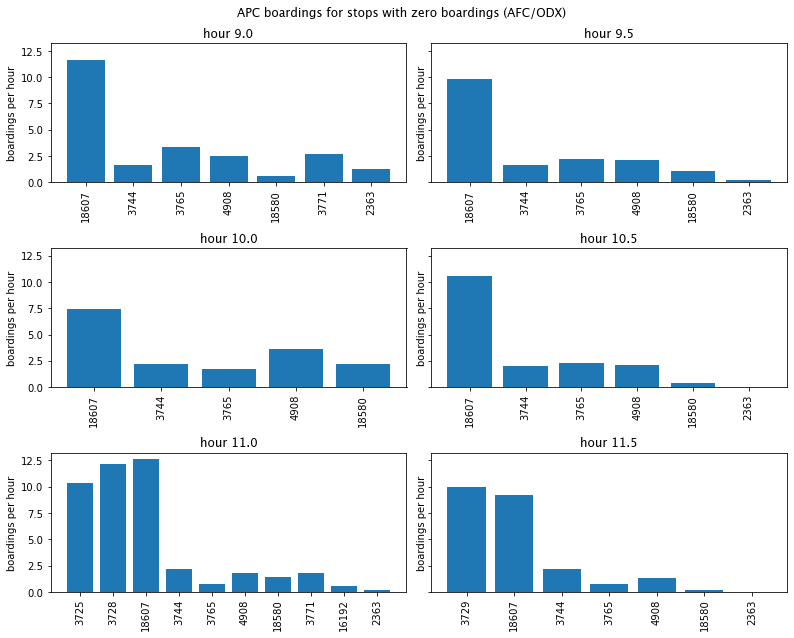

In [108]:
plt.close()
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 9), sharey='all')
for bin_n in range(18, 24):
#     print(f'---- BIN {bin_n}')
    x1, x2 = get_zero_ons_stops(odt_ons, stops_east, bin_n, on_rates)
    n = bin_n - 18
    axs.flat[n].bar(np.arange(len(x1)), x2)
    axs.flat[n].set_xticks(np.arange(len(x1)))
    axs.flat[n].set_xticklabels(x1, rotation=90)
    axs.flat[n].set_title(f'hour {round(bin_n/2,1)}')
    axs.flat[n].set_ylabel('boardings per hour')
#     axs.flat[n].legend()
#     print(x1)
#     print(x2)
plt.suptitle('APC boardings for stops with zero boardings (AFC/ODX)')
plt.tight_layout()
plt.show()

In [151]:
def extract_cv_hw(avl_df, dates, t0_str, t1_str, stops):
    cv_hws = []
    for n in range(len(stops)):
        stop_avl_df = avl_df[avl_df['stop_sequence'] == n+1].copy()
        hws = []
        for d in dates:
            t0 = pd.Timestamp(d + ' ' + t0_str)
            t1 = pd.Timestamp(d + ' ' + t1_str)
            temp_avl_df = stop_avl_df.copy()
            temp_avl_df['arr_time_dt'] = pd.to_datetime(temp_avl_df['arr_time'])
            temp_avl_df = temp_avl_df[(temp_avl_df['arr_time_dt'] >= t0) &
                                     (temp_avl_df['arr_time_dt'] <= t1)].copy()
            if not temp_avl_df.empty:
                temp_avl_df = temp_avl_df.sort_values(by='arr_sec').copy()
                temp_avl_df = temp_avl_df.drop_duplicates(subset=['trip_id']).copy()
                temp_avl_df = temp_avl_df.assign(next_arr_sec=temp_avl_df['arr_sec'].shift(-1))
                temp_avl_df['hw'] = temp_avl_df['next_arr_sec'] - temp_avl_df['arr_sec']
                temp_avl_df = temp_avl_df[temp_avl_df['hw'].notnull()].copy()
#                 print(temp_avl_df['hw'])
                hws += temp_avl_df['hw'].tolist()
        mean_hw = np.mean(hws)
        sd_hw = np.std(hws)
        cv_hws.append(sd_hw/mean_hw)
    return cv_hws

In [152]:
from ins.Fixed_Inputs_81 import DATES
from Variable_Inputs import STOPS_OUT_FULL_PATT
avl = pd.read_csv('ins/rt_81_2022-05/avl.csv')
cv = extract_cv_hw(avl, DATES, '06:00:00', '07:00:00', STOPS_OUT_FULL_PATT)
print(cv)

[0.856367406407021, 0.8271697823064851, 0.8310923982917467, 0.8214924002138344, 0.8279668167761082, 0.8350888848001687, 0.8287547580298482, 0.8270788891451452, 0.8298754270630645, 0.8299852355095564, 0.8206314521978119, 0.7346568541910752, 0.7327415809321021, 0.841203377273876, 0.8398597825235131, 0.7974186947497797, 0.7149185550565486, 0.7170524881579664, 0.7209380878267883, 0.7243824751063956, 0.7309699856063444, 0.7689892163937911, 0.754205720257597, 0.7592717341194801, 0.7498182231013193, 0.7645339772933902, 0.775669135409758, 0.7845913734780238, 0.7934461190053541, 0.7970914994123034, 0.7694616459212504, 0.7547057228906342, 0.7631264306860666, 0.7648175714862222, 0.7579676347715649, 0.7668772161595526, 0.7904070134824022, 0.7564977155268914, 0.7688382607068197, 0.8401843564500711, 0.7833140465300739, 0.7998921839062878, 0.7760316117510235, 0.7664269273863971, 0.77782474490349, 0.7758516656299237, 0.7962045859797822, 0.7934224145189729, 0.9486666874949646]


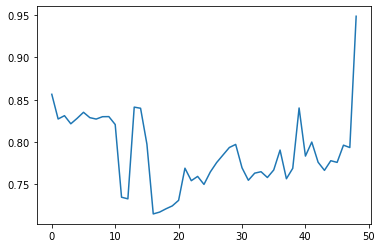

In [153]:
plt.plot(cv)

In [8]:
df = pd.read_pickle('outs/rt_81_2022-05/DSX/0811-114719-trip_record_ob.pkl')

In [21]:
df[(df['stop_sequence']==1) & (df['replication'] == 1)]

,bus_id,trip_id,stop_id,arr_sec,dep_sec,pax_load,ons,offs,denied,hold_time,skipped,schd_sec,stop_sequence,dist_traveled,expressed,replication
0,1628,22229020,14102,18548.367394,18553.040137,2,2,0,0,0,0,18510.0,1,0,0,1
23,1594,40540020,14102,19319.986359,19327.884603,3,3,0,0,0,0,19200.0,1,0,0,1
53,1632,34695020,14102,19872.246447,19874.642833,2,2,0,0,0,0,19800.0,1,0,0,1
92,1626,40615020,14102,20442.691870,20448.290196,2,2,0,0,0,0,20340.0,1,0,0,1
132,1629,21274020,14102,20934.145098,20934.145098,4,4,0,0,0,0,20880.0,1,0,0,1
176,1627,6210020,14102,21447.072549,21447.072549,2,2,0,0,0,0,21420.0,1,0,0,1
225,1592,41806020,14102,21997.582361,22011.382361,6,6,0,0,0,0,21960.0,1,0,0,1
281,1634,10663020,14102,22680.000000,22680.000000,6,6,0,0,0,0,22500.0,1,0,0,1
342,1625,26531020,14102,23456.874876,23493.781907,16,16,0,0,0,0,23460.0,1,0,0,1
377,1628,35580020,14102,23911.890954,23911.890954,7,7,0,0,0,0,23910.0,1,0,0,1


In [11]:
24426020

6.858333333333333